# Tile Detection

As we don't completely know which tiles belong to which Nova-ST chips, we need to detect this using the data itself.

We do this by checking a small subset of the reads from the spatial data vs. the subset files we saved from the HDMI analysis earlier

In [140]:
import pickle
from collections import defaultdict

import pysam
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [141]:
tiles_dir = '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data/'
subsets = defaultdict(dict)
for lane in range(1, 2):
    for surface in range(1, 3):
        for swath in range(1, 7):
            for tile in range(1,12):
                filenum = f'{surface}{swath}{tile:02}'
                if (filenum == "2206"):
                    continue
                with open(f'{tiles_dir}/{surface}{swath}{tile:02}_subset_barcodes.pickle', 'rb') as fh:
                    subsets[f'{surface}{swath}{tile:02}'] = pickle.load(fh)

In [142]:
tile = 2
f'{surface}{swath}{tile:02}'

'2602'

In [ ]:
subsets    # do not print this

In [144]:
data_dir = "/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data_with_UMI/" # Demultiplexed spatial libraries

In [41]:
samples = ["AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1"
    # Put the names of the samples here, this should match the demultiplexing sheet and will be appended with _R1_001.fastq.gz later
]

In [51]:
samples_data = defaultdict(set)

We load the first 100k barcodes from each sample to profile this small subset of reads

In [146]:
for sample in samples:
    print(f'On {sample}:')
    with pysam.FastqFile('/prj/NovaST/Dieterich_AAGMTVHM5/data/per_tile_data_with_UMI/AAGMTVHM5_NovaST_25s000253-1-1_UMI_tile_1101.fastq.gz', persist=False) as fh:
        for en, entry in enumerate(fh):
            seq = entry.sequence[:32]
            samples_data[sample].add(seq)
            
            if (en + 1) % 100000 == 0:
                print(f'    Finished {en + 1} reads')
                break


On AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1:
    Finished 100000 reads


In [ ]:
# samples_data[sample]
samples_data.items()

Plot the barcode pattern from the spatial library and ensure it looks correct

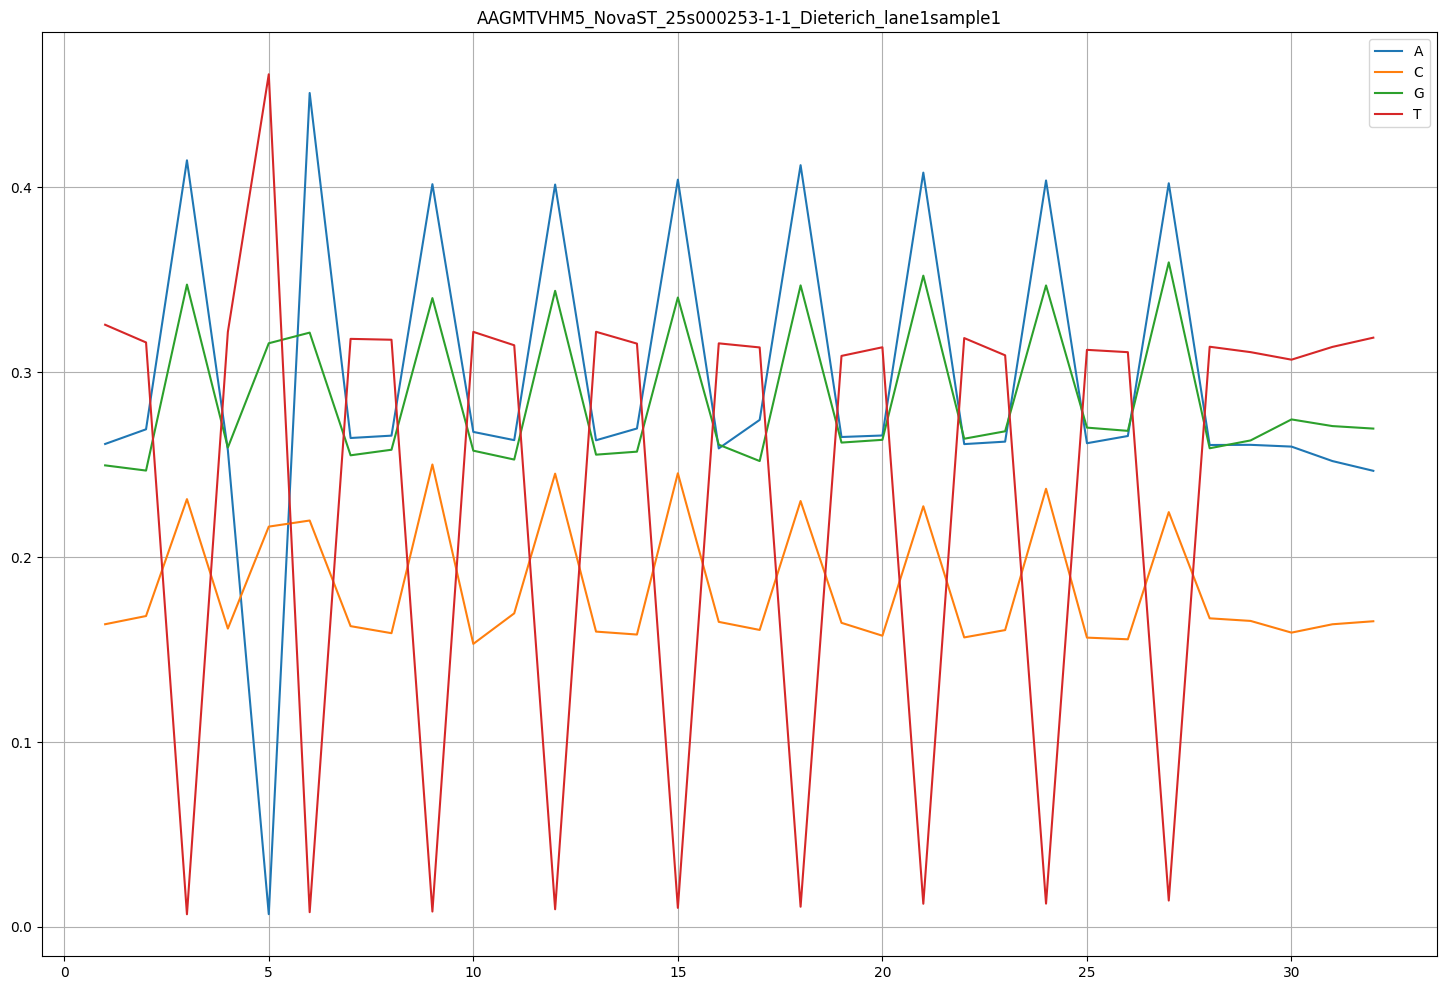

In [149]:
for sample in samples:
    base_pairs = defaultdict(lambda: defaultdict(lambda: 0))
    for seq in samples_data[sample]:
        for n, base in enumerate(seq):
            base_pairs[n][base] += 1
        if (en) % 1000000 == 0:
            print(f'Finished {en} reads')
            break 

    bp_df = pd.DataFrame(base_pairs, index=['A', 'C', 'G', 'T', 'N'])

    bp_df = bp_df.drop('N')
    bp_df.columns = [int(x) + 1 for x in bp_df.columns]

    bp_df/bp_df.sum()



    (bp_df/bp_df.sum()).T.plot(kind='line', figsize=(18, 12))
    plt.grid(True, which='major')
    plt.title(sample)


In [150]:
# Helper functions to convert tiles to plotted columns and back again

def get_x(lane, surface, swath):
    # Return x coordinate of the tile, swaths are grouped, each lane has 2 surfaces, each surface has 6 swaths, add a gap of 1 between every surface
    return (lane - 1) * 14 + (surface - 1) * 7 + swath    

def reverse_get_x(x):
    # Return lane, surface, swath of the tile
    # 1 -> 1, 1, 1
    # 2 -> 1, 1, 2
    # 7 -> None
    # 8 -> 1, 2, 1
    # 44 -> 4, 1, 2

    lane = (x - 1) // 14 + 1
    surface = ((x - 1) % 14) // 7 + 1
    swath = ((x - 1) % 14) % 7 + 1
    return lane, surface, swath


In [151]:
(lane - 1) * 14 + (surface - 1) * 7 + swath 

13

Here, we count how many times we see a barcode from each tile (subset) in the reads we took from the library

In [ ]:
lanes = 1
surfaces = 2
swaths = 6
tiles = 11
counts_dfs = {}
for s, data in samples_data.items():
    df = pd.DataFrame(
        data=np.nan,
        columns=list(range((lanes * surfaces * swaths) + lanes + surfaces + 1)),
        index=[x for x in range(1, tiles + 1)],
    )
    col = 0
    for lane in range(1, lanes + 1):
        for surface in range(1, surfaces + 1):
            for swath in range(1, swaths + 1):
                for tile_n in range(1, tiles + 11):
                    for tile, tile_bcs in subsets[f"{surface}{swath}{tile_n:02}"].items():
                        #print(lane, surface, swath, tile, tile_bcs)
                        print(tile_bcs)
                        x = get_x(lane, surface, swath) - 1
                        print(x)
                        y = int(tile_bcs[1])
                        df.loc[y, x] = len(tile_bcs & data)

    counts_dfs[s] = df

In [160]:
subsets['1102'].keys()

dict_keys(['02'])

Higlight every tile where one or more reads was identified to visually inspect where the tissue is

In [ ]:
fig, axs = plt.subplots(1, len(samples) ,figsize=((20 * len(samples)), 78), facecolor='white')
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='black')
for ax, sample, df in zip(axs, counts_dfs.keys(), counts_dfs.values()):
    ax.imshow(df, vmax=1, vmin=0, )
    ax.set_title(sample)

In [109]:
counts_dfs.keys()

dict_keys(['AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1'])

In [101]:
def extract_whitelist(start, end, path, lane=1, surface=1, swaths=[1, 2, 3, 4, 5, 6], trim_to_31=True, sample=None):
    final_path = f"{path}/whitelist"
    if sample:
        final_path += f"_{sample}"
    final_path += f"_{lane}_{surface}_tiles_{start}_to_{end}"
    if trim_to_31:
        final_path += "_31bp"
    final_path += ".tsv"

    with open(final_path, "w") as whitelist_fh:
        for tile_y in range(start, end + 1):
            for swath in swaths:
                tile = f"{surface}{swath}{tile_y}"
                print(tile_y)
                tile_file = f"{tiles_dir}/AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane{lane}sample1_1_sequence_tile_{tile}_barcodes.pickle"
                with open(tile_file, "rb") as tile_fh:
                    tile_data = pickle.load(tile_fh)
                for bc in tile_data.keys():
                    if trim_to_31:
                        whitelist_fh.write(f"{bc[:31]}\n")
                    else:
                        whitelist_fh.write(f"{bc}\n")
        return final_path

Detect the surface for each sample

In [105]:
tile_file = f"{tiles_dir}/AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane{lane}sample1_1_sequence_tile_{tile}_barcodes.pickle"
tile_file
start = -2
end = 14
for tile_y in range(start, end + 1):
    print(tile_y)

-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [106]:
counts_dfs[sample]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
sample_surface_detections = {}
for sample, df in counts_dfs.items():
    surface_counts = defaultdict(int)
    for ix, val in df.sum().items():
        lane, surface, swath = reverse_get_x(ix+1)
        surface_counts[f"{lane}_{surface}"] += val

    max_lane, max_surface = max(surface_counts, key=surface_counts.get).split("_")[0:2]
    sample_surface_detections[sample] = (max_lane, max_surface)

Save identify the exact tiles, create and save the whitelist for each sample

AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1 1 1
     0   1   2   3   4   5
1  NaN NaN NaN NaN NaN NaN
2  NaN NaN NaN NaN NaN NaN
3  NaN NaN NaN NaN NaN NaN
4  NaN NaN NaN NaN NaN NaN
5  NaN NaN NaN NaN NaN NaN
6  NaN NaN NaN NaN NaN NaN
7  NaN NaN NaN NaN NaN NaN
8  NaN NaN NaN NaN NaN NaN
9  NaN NaN NaN NaN NaN NaN
10 NaN NaN NaN NaN NaN NaN
11 NaN NaN NaN NaN NaN NaN
AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1 - 1_1 - -2 to 14
-2 14 /prj/NovaST/Dieterich_AAGMTVHM5/data/barcode_whitelist/ 1 1
-2


FileNotFoundError: [Errno 2] No such file or directory: '/prj/NovaST/Dieterich_AAGMTVHM5/data/HDMI_Tiles_Data//AAGMTVHM5_NovaST_25s000253-1-1_Dieterich_lane1sample1_1_sequence_tile_11-2_barcodes.pickle'

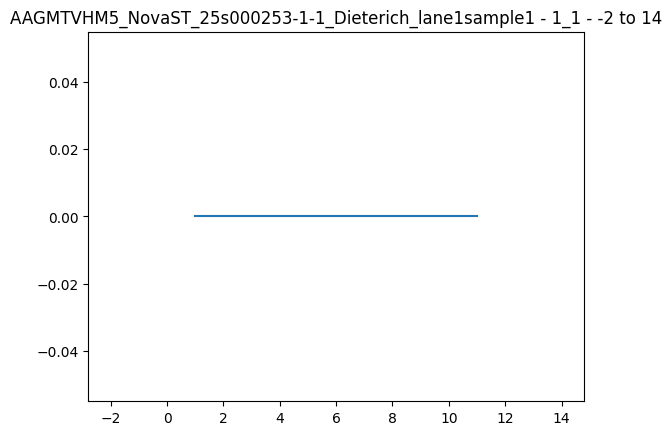

In [104]:
path = "/prj/NovaST/Dieterich_AAGMTVHM5/data/barcode_whitelist/"

for sample, (lane, surface) in sample_surface_detections.items():
    print(sample, lane, surface)
    # Detect edges tile
    THRESHOLD = 2

    x = get_x(int(lane), int(surface), 1) - 1
    selected_counts = counts_dfs[sample].loc[:, x : x + 5]
    selected_counts = selected_counts.loc[:, (selected_counts != 0).any(axis=0)]
    selected_counts[selected_counts < THRESHOLD] = 0
    print(selected_counts)
    first = int(selected_counts.ne(0).idxmax().median()) - 3
    last = int(selected_counts.iloc[::-1].ne(0).idxmax().median()) + 3
    print(f"{sample} - {lane}_{surface} - {first} to {last}")
    plt.figure()
    cumsum = counts_dfs[sample].loc[:, x : x + 5].sum(axis=1).cumsum()
    plt.plot(cumsum)
    plt.title(f"{sample} - {lane}_{surface} - {first} to {last}")
    plt.vlines(first, 0, cumsum.max(), colors="red")
    plt.vlines(last, 0, cumsum.max(), colors="red")

    print(first, last, path, lane, surface)
    extract_whitelist(first, last, path, lane=lane, surface=surface, trim_to_31=True, sample=sample)